<a href="https://www.kaggle.com/code/emmanuelniyioriolowo/ct-hematoma-classifier-v2-multi-class?scriptVersionId=274364890" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# CT Hematoma Classifier – Multi-class

Welcome to my CT Hematoma Classifier. This project is designed as a multi-class image classification model for brain CT scans.

---

## Overview

Although the ultimate goal is a multi-class classifier for different types of hematomas, this initial version focuses on creating a small dataset, training a model, automatically testing it, and calculating accuracy.  

The model is trained using images collected from the internet. The dataset is somewhat “dirty” and contains errors, but this approach allows rapid experimentation and testing.  

In future versions, I plan to:
- Scrape, clean, and validate a larger, high-quality dataset to improve model reliability.
- Implement data augmentation strategies to enhance model generalization and accuracy.

Explore explainability techniques (e.g., Grad-CAM or feature attribution) to visualize model reasoning and build clinician trust.

---

## Key Steps in This Notebook

1. **Setup and Library Installation**  
   - Import essential Python libraries (`numpy`, `pandas`, `fastai`, `ddgs`, `requests`).  
   - Ensure correct versions are installed for compatibility.

2. **Image Downloading**  
   - Search and download sample images for each category using `DDGS` and `requests`.  
   - Display thumbnails to verify successful downloads.

3. **Dataset Preparation**  
   - Organize images into category folders.  
   - Verify and remove broken or unreadable images.  
   - Resize images to a consistent size for model input.

4. **Data Loading and Transformation**  
   - Create a `DataBlock` with an 80/20 train-validation split.  
   - Apply image resizing transformations for model training.  
   - Display a batch of images to visually inspect the dataset.

5. **Model Training**  
   - Create a `ResNet18` vision learner.  
   - Fine-tune the pretrained model for 3 epochs.  
   - Track performance using `error_rate`.

6. **Validation and Accuracy Calculation**  
   - Load a separate validation dataset.  
   - Predict classes for all images and save results to CSV.  
   - Compute per-category and overall accuracy.
7. **Testing with New Images**  
   - Download sample test images.  
   - Predict categories using the trained model.  
   - Display predicted class and probability of being an epidural hematoma.

---

## Notes

- This version is primarily experimental and focuses on workflow: dataset creation, model training, testing, and evaluation.  
- Dataset quality is limited due to reliance on uncurated internet images.  
- Future versions will focus on cleaning datasets and improving accuracy.

---

## License / Disclaimer

This notebook is for learning and experimentation purposes. The model is **not intended for clinical use**, and the dataset may contain mislabeled or incorrect images. Always consult a qualified professional for medical diagnoses.

In [1]:
# Update libraries 
# numpy==1.26.4 is installed separately to resolve a dependency conflict I encountered during setup.

import numpy as np 
import pandas as pd 
import os
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq numpy==1.26.4 fastai ddgs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.1/235.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5

In [2]:
# import required libraries and define a function to search and return image urls for given keywords using ddgs

from ddgs import DDGS 
from fastcore.all import *
from fastai.vision.all import *
import time, json

def search_images(keywords, max_images=200):
    "Search and return a list of image URLs for given keywords"
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
# define main hematoma-related CT classes and additional non-brain scan classes, then combine them into one list

main_classes = ['normal brain CT', 'epidural hematoma CT', 'intracerebral hematoma CT', 'subdural hematoma CT', 'subarachnoid hematoma CT']
other_classes = ['abdominal CT', 'cervical CT', 'lower cranial CT', 'thoracic CT', 'abdominal x ray', 
                 'chest xray', 'knee xray', 'shoulder  xray', 'skull xray', 'foot xray']
combined_classes = main_classes + other_classes

In [4]:
# create folders for each class, download images from the internet, and resize them to 400px for dataset preparation

from fastdownload import download_url
path = Path('hematoma_traning_ds')


for class_ in combined_classes:
    max_images=200
    if class_ in main_classes:
        dest = (path/class_)
    else:
        dest = (path/'others')
        max_images=20
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(class_, max_images))
    time.sleep(5)
    resize_images(dest, max_size=400, dest=dest)

In [5]:
# verify all downloaded images and remove any corrupted or unreadable files from the dataset

from fastai.vision.all import *
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

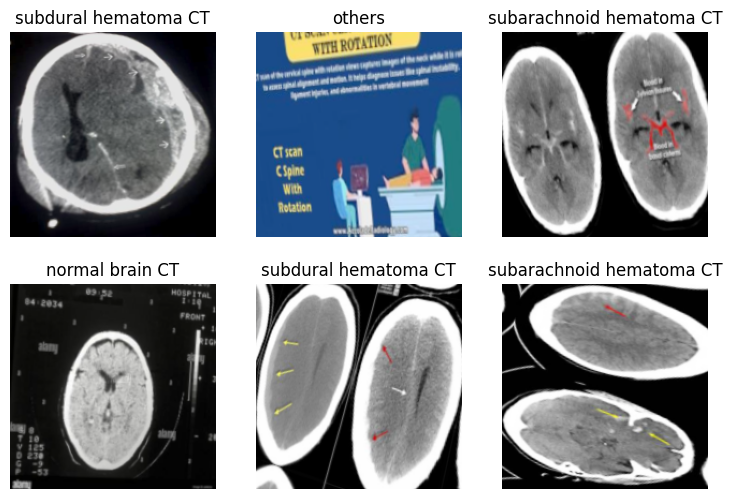

In [6]:
# create a fastai datablock for image classification with an 80/20 train-validation split and display sample images


# data augmentation
batch_tfms=aug_transforms(
        do_flip=True,
        flip_vert=True,
        max_rotate=20.0,
        max_zoom=1.1,
        max_lighting=0.2,
        max_warp=0.1,
        p_affine=0.75,
        p_lighting=0.75
    )


dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    # resize all images to 192x192 using squish method
    item_tfms=[Resize(192, method='squish')],
    batch_tfms=batch_tfms
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [7]:
# fine-tune pretrained resnet18 model for 3 epochs

metrics=[
        error_rate,
        accuracy,
        Precision(average='macro'),
        Recall(average='macro'),
        F1Score(average='macro')
    ]

learn = vision_learner(dls, resnet18, metrics=metrics)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 91.9MB/s]


epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,f1_score,time
0,2.332433,2.161684,0.584270,0.415730,0.314795,0.343231,0.305876,00:25


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,f1_score,time
0,1.721543,1.457974,0.505618,0.494382,0.381863,0.388731,0.368511,00:34
1,1.465667,1.388843,0.471910,0.528090,0.382804,0.424165,0.399355,00:33
2,1.309874,1.388577,0.471910,0.528090,0.388767,0.424165,0.403555,00:33


### Evaluation with the validation split of the original dataset

In [8]:
from sklearn.metrics import classification_report
import torch

# Get predictions and targets from validation set
preds, targs = learn.get_preds()

# Convert probabilities to predicted class indices
pred_classes = torch.argmax(preds, dim=1)

# Generate classification report
print(classification_report(targs, pred_classes, target_names=learn.dls.vocab))

                           precision    recall  f1-score   support

     epidural hematoma CT       0.38      0.50      0.43        10
intracerebral hematoma CT       0.54      0.58      0.56        12
          normal brain CT       0.38      0.47      0.42        17
                   others       0.93      0.93      0.93        28
 subarachnoid hematoma CT       0.00      0.00      0.00         6
     subdural hematoma CT       0.10      0.06      0.08        16

                 accuracy                           0.53        89
                macro avg       0.39      0.42      0.40        89
             weighted avg       0.50      0.53      0.51        89



[('subdural hematoma CT', 'normal brain CT', 7),
 ('normal brain CT', 'intracerebral hematoma CT', 5),
 ('epidural hematoma CT', 'subdural hematoma CT', 4),
 ('subdural hematoma CT', 'epidural hematoma CT', 4),
 ('subdural hematoma CT', 'subarachnoid hematoma CT', 3),
 ('intracerebral hematoma CT', 'normal brain CT', 2),
 ('normal brain CT', 'subdural hematoma CT', 2),
 ('subarachnoid hematoma CT', 'normal brain CT', 2),
 ('subarachnoid hematoma CT', 'subdural hematoma CT', 2)]

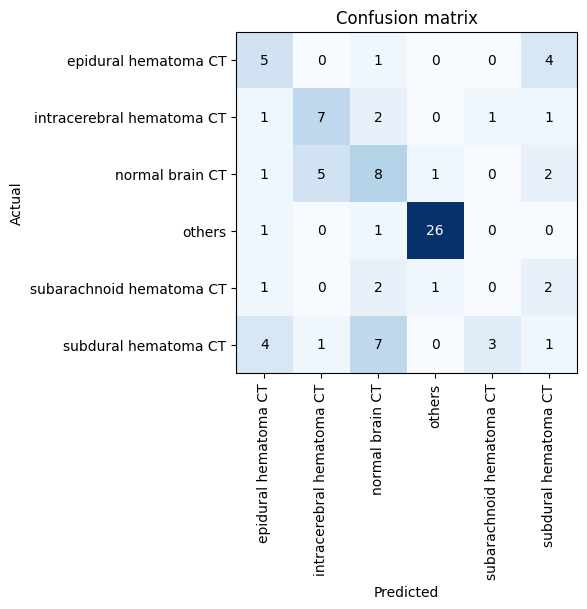

In [9]:
interpretation = ClassificationInterpretation.from_learner(learn)
interpretation.plot_confusion_matrix(figsize=(6,6), dpi=100)
interpretation.most_confused(min_val=2)

### Evaluation with the validation dataset

In [10]:
# run model predictions on all images in the validation dataset, compare them with true labels, save results to a CSV file, and preview the first 60 entries

import pandas as pd
test_path = Path('/kaggle/input/hematoma-classifier-validation-dataset/')

results = []
all_file_paths = test_path.rglob('*')

for img_path in all_file_paths:
    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
        # Extract the true label from the parent folder name
        true_label = img_path.parent.name
    
        # Get prediction from the model
        pred_class, pred_idx, probs = learn.predict(img_path)
        

        # determine correctness: match true label with predicted class considering 'not' categories
        correct = False
        if true_label in pred_class and "not" not in pred_class:
            correct = True
        elif true_label not in pred_class and "not" in pred_class:
            correct = True
        
        # Append to list
        results.append({
            'filename': img_path.name,
            'true_label': true_label,
            'predicted_class': pred_class,
            'correct': correct 
        })

# Convert to DataFrame
df_results = pd.DataFrame(results)

In [11]:
# define a function to compute per-category and overall model accuracy, then display the results

def compute_accuracy(df):
    """
    Computes per-subcategory and overall accuracy.
    Expects columns: ['true_label', 'correct']
    """
    # Per subcategory (grouped by true_label)
    subcategory_accuracy = (
        df.groupby('true_label')['correct']
        .mean()                           # average True/False = accuracy
        .sort_index()                     # sort alphabetically
    )

    # Overall accuracy
    overall_accuracy = df['correct'].mean()

    return subcategory_accuracy, overall_accuracy


subcategory_acc, overall_acc = compute_accuracy(df_results)

print("📊 Accuracy per subcategory:\n", subcategory_acc)
print("✅ Overall accuracy: {:.2f}%".format(overall_acc * 100))

📊 Accuracy per subcategory:
 true_label
epidural         0.583333
intracerebral    0.090909
normal           0.875000
others           0.700000
subarachnoid     0.400000
subdural         0.076923
Name: correct, dtype: float64
✅ Overall accuracy: 42.19%


In [12]:
new = [pred.split()[0] for pred in df_results['predicted_class']]
y_pred = pd.Series(new)
y_true = df_results['true_label']

In [13]:
# Get predictions and targets from validation set
preds, targs = learn.get_preds()

# Generate classification report
print(classification_report(y_true, y_pred))

               precision    recall  f1-score   support

     epidural       0.41      0.58      0.48        12
intracerebral       0.50      0.09      0.15        11
       normal       0.28      0.88      0.42         8
       others       1.00      0.70      0.82        10
 subarachnoid       0.36      0.40      0.38        10
     subdural       0.50      0.08      0.13        13

     accuracy                           0.42        64
    macro avg       0.51      0.45      0.40        64
 weighted avg       0.51      0.42      0.39        64



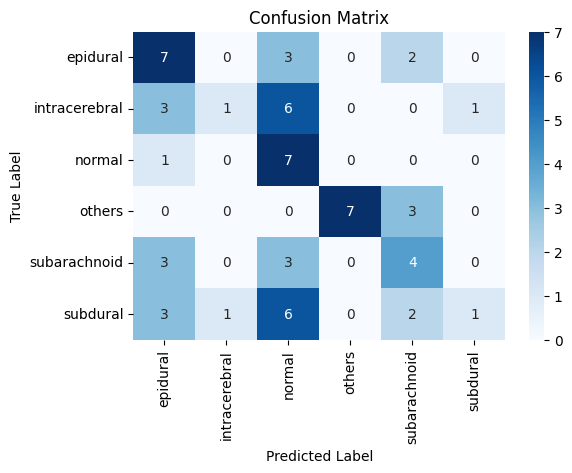

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y_true.unique()),
            yticklabels=sorted(y_true.unique()))

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# # Downloads and displays a 256×256 thumbnail of an intracerebral hematoma CT image.
# test_image = "thoracic ct"
# urls = search_images(test_image, max_images=1)
# dest = f'{test_image}.jpg'
# download_url(urls[0], dest, show_progress=False)

# from fastai.vision.all import *
# img = Image.open(dest)
# img.to_thumb(256,256)

In [16]:
# # Predicts the hematoma type from the image and displays the predicted category with its probability.
# resultant_category,_,probs = learn.predict(PILImage.create(f'{test_image}.jpg'))
# print(f"Predicted category: {resultant_category}")
# print(f"Probability of epidural hematoma: {probs[0]:.4f}")

In [17]:
# # Creates and displays an image upload widget for selecting a single image file. To test with local files
# from ipywidgets import FileUpload
# from fastai.vision.all import PILImage

# # Display uploader
# uploader = FileUpload(accept='image/*', multiple=False)
# display(uploader)

In [18]:
# # Loads the uploaded image, uses the trained model to predict its category, and displays the prediction with class probabilities.

# if uploader.value:
#     uploaded_file = uploader.value[0]
#     img_bytes = bytes(uploaded_file['content']) 

#     img = PILImage.create(img_bytes)  

#     # Predict
#     resultant_category, _, probs = learn.predict(img)
#     print(f"Predicted category: {resultant_category}")
#     print(f"Probabilities: {probs}")
# else:
#     print("Please upload an image first.")

## Development & Experimentation Log

### Project Title: CT Hematoma Classifier – Multi-class

**Author:** Emmanuel Niyi-Oriolowo  
**Repository:** CT Hematoma Classifier – Multi-class  
**Date Started:** 2025-10-30  
**Purpose:** To systematically document experiments, reasoning, and technical changes throughout the model development process.


### Entry — 06-11-2025

#### 🔧 Changes Implemented

-   Implemented model performance evaluation on both the internal validation split and an external dataset. Computed confusion matrix, precision, recall, and F1-score for both datasets.
    
-   For the external dataset, used scikit-learn directly to better understand the underlying evaluation process used by fastai.
    

#### 📊 Results / Observations
- Internal: 64% accuracy, macro F1 = 0.47.
- External: 41% accuracy, macro F1 = 0.40.
- Noted drop in generalization, with high precision but low recall on minority hematoma classes.
- 

#### 💭 Reflections / Hypotheses

-   Documentation needs improvement once evaluation results are logged more systematically.
    
-   Current accuracy and precision remain relatively low — likely due to limited and/or noisy training data.
    

#### 🧭 Next Steps
-   Explore potential improvements to data quality and validation strategy:
    
    -   **Option 1:** Switch the image search engine to Google for higher-quality images (though this may increase cost).
        
    -   **Option 2:** Use my current validation data (small) and apply augmentation, adjusting the training–validation split to around 60/40. The drawback is that I’ll lose an independent validation set, which makes it harder to detect overfitting.
        
    -   **Option 3:** Download and clean search-engine images offline to create a more controlled training dataset, ensuring no overlap with current validation data.

 

### Entry — 07-11-2025

#### 🔧 Changes Implemented

-   Added data augmentation 
    

#### 📊 Results / Observations
- Changes to accuracy and F1 were minimal in both internal and external data sets 

#### 💭 Reflections / Hypotheses

-   I think augmentation was not so significant because the initial data was of low quality.
-   Another issue i noticed was the inconsistency in the results because the search_images function retruns different images on each run. So each session is run on a different data set
-   This makes tracking changes and progress more difficult
-   The best step would be to adopt option 3 where I manually clean a downloaded dataset offline
    

#### 🧭 Next Steps
        
    -  Download and clean search-engine images offline to create a more controlled training dataset, ensuring no overlap with current validation data.
    -  Look in to Grad-CAM